# Faces

In [9]:
import os
import torch
from facenet_pytorch import InceptionResnetV1,MTCNN
from PIL import Image, ImageDraw

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

In [97]:
# Read csv file with image information
df = pd.read_csv("Friends-Image-Data.csv")
# Ensure all image paths in the DataFrame are valid
assert len(df) == df['path'].apply(os.path.isfile).sum(), "not all paths in DataFrame are valid"

df["id"] = df["path"].apply(lambda x: os.path.basename(x).split(".")[0])

print(df.shape)
df.head()

(348, 5)


,label,path,img_width,img_height,id
0,Combined,./data/Friends/Test/all (1).jpeg,1080,1080,all (1)
1,Combined,./data/Friends/Test/all (10).jpg,236,303,all (10)
2,Combined,./data/Friends/Test/all (11).jpg,750,445,all (11)
3,Combined,./data/Friends/Test/all (12).jpg,1400,1400,all (12)
4,Combined,./data/Friends/Test/all (13).jpg,1522,1542,all (13)


# FaceNet

- [FaceNet Kaggle Guide](https://www.kaggle.com/code/timesler/guide-to-mtcnn-in-facenet-pytorch)
- [FaceNet PyPi](https://pypi.org/project/facenet-pytorch/)
- [FaceNet Medium](https://medium.com/@danushidk507/facenet-pytorch-pretrained-pytorch-face-detection-mtcnn-and-facial-recognition-b20af8771144)
- [FaceNet Output](https://discuss.pytorch.org/t/pytorch-facenet-mtcnn-image-output/99683)

## Get Face Embeddings

In [92]:
save_path = os.path.join("data", "Friends", "Faces")

# Initialize MTCNN for face detection
mtcnn = MTCNN(
    image_size=160,
    margin=0,
    min_face_size=20,
    thresholds=[0.6, 0.7, 0.7],
    factor=0.709,
    post_process=True,
    select_largest=False,
    selection_method=None,
    keep_all=True,
    device=None
)

# Load pre-trained FaceNet model
resnet = InceptionResnetV1(pretrained='casia-webface').eval()

file_id, file_names, probabilites_out, embeddings_out = [], [], [], []

for i, row in df.iterrows():

    if i % 25 == 0:
        print(f"Starting [{i:03}/{len(df):03}]")

    path = row['path']

    base_name = os.path.basename(path).split(".")[0]

    # Load an image containing faces as a RGB image
    img = Image.open(path).convert("RGB")

    # Detect faces in the image
    boxes, probabilities = mtcnn.detect(img)

    # If faces are detected, extract embeddings
    if boxes is not None:
        aligned = mtcnn(img, save_path=os.path.join(save_path, f"{base_name}.jpg"))
        embeddings = resnet(aligned).detach()

        n_rows = len(embeddings)

        f_names = [f"{base_name}.jpg"] + [f"{base_name}_{k+1}.jpg" for k in range(n_rows) if k > 0]
        b_names = [base_name for k in range(n_rows)]

        file_id += b_names
        file_names += f_names

        probabilites_out.append(probabilities)
        embeddings_out.append(embeddings)

    

probabilites_out = np.concatenate(probabilites_out)
embeddings_out = np.vstack(embeddings_out)

df_out = pd.DataFrame({
    "id": file_id,
    "file-name": file_names, 
    "probability": probabilites_out
})

df_embed = pd.DataFrame(embeddings_out)

df_out = pd.concat([df_out, df_embed], axis=1)

df_out.to_csv("Friends-Face-Data.csv", index=False)

Starting [000/348]
Starting [025/348]
Starting [050/348]
Starting [075/348]
Starting [100/348]
Starting [125/348]
Starting [150/348]
Starting [175/348]
Starting [200/348]
Starting [225/348]
Starting [250/348]
Starting [275/348]
Starting [300/348]
Starting [325/348]


In [119]:
df_all = pd.merge(left=df, right=df_out, on="id", how="inner")
df_all.to_csv("Friends-Embedding-Data.csv", index=False)
print(df_all.shape)
df_all.head()

(533, 519)


,label,path,img_width,img_height,id,file-name,probability,0,1,2,...,502,503,504,505,506,507,508,509,510,511
0,Combined,./data/Friends/Test/all (1).jpeg,1080,1080,all (1),all (1).jpg,0.999996,0.016463,-0.035147,0.022421,...,-0.005775,0.037893,0.030448,-0.010769,-0.029652,-0.007674,0.031602,-0.050520,0.052904,0.011334
1,Combined,./data/Friends/Test/all (1).jpeg,1080,1080,all (1),all (1)_2.jpg,0.999499,0.025601,0.025191,-0.001330,...,-0.120619,-0.011368,-0.021438,-0.007787,-0.014309,-0.060678,0.038594,-0.016644,0.013772,0.015691
2,Combined,./data/Friends/Test/all (1).jpeg,1080,1080,all (1),all (1)_3.jpg,0.720533,0.057449,0.053806,-0.070159,...,0.055271,0.015989,0.024392,-0.007668,-0.050123,0.064430,-0.048710,0.004330,0.038965,0.041589
3,Combined,./data/Friends/Test/all (10).jpg,236,303,all (10),all (10).jpg,0.99977,0.008133,0.064237,0.018680,...,0.010612,0.038143,-0.052736,-0.071410,-0.009543,-0.021991,-0.006214,0.049135,-0.061862,0.020988
4,Combined,./data/Friends/Test/all (10).jpg,236,303,all (10),all (10)_2.jpg,0.995793,-0.074850,-0.043276,0.018326,...,0.035347,0.038942,-0.027466,0.013353,0.030153,0.031843,0.013925,0.015101,0.036377,-0.006281


## Explore Face Embeddings

# Other

In [36]:
class FaceDetection:
    """
    """
    def __init__(self, detection_threshold=0.95):
        """
        """

        # Specify a face detection threshold
        self.detection_threshold = detection_threshold

        # Initialize MTCNN for face detection
        self.mtcnn = MTCNN(
            image_size=160,
            margin=0,
            min_face_size=20,
            thresholds=[0.6, 0.7, 0.7],
            factor=0.709,
            post_process=False,
            select_largest=False,
            selection_method=None,
            keep_all=True,
            device=None
        )

        # Load pre-trained FaceNet model for embedding 
        self.embedding_model = InceptionResnetV1(pretrained='casia-webface').eval()


    def load_image(self, path):
        """
        """
        # Load an image containing faces as a RGB image
        return Image.open(path).convert("RGB")
    
    def detect_embedd(self, path):
        """
        """

        # Load Image
        img = self.load_image(path)

        # Detect faces in the image
        boxes, probabilities = self.mtcnn.detect(img)

        detection_mask = probabilities > self.detection_threshold

        boxes = boxes[detection_mask]
        probabilities = probabilities[detection_mask]

        # If faces are detected, extract embeddings
        if boxes is not None:
            aligned = self.mtcnn(img)
            aligned = aligned[detection_mask]

            embeddings = self.embedding_model(aligned).detach()

        else:
            aligned = None
            embeddings = None

        return embeddings, aligned, boxes, probabilities

In [37]:
fd = FaceDetection()

In [39]:
# sample combined images
img_paths = df[df['label']=='Combined'].sample(10)['path'].values

embeddings, aligned, boxes, probabilities = fd.detect_embedd(img_paths[0])

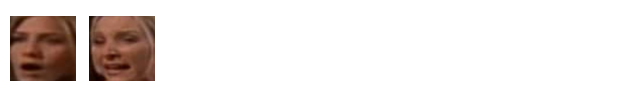

In [40]:
# Visualize faces
fig, ax = plt.subplots(ncols=8, figsize=(8,1))

for i in range(8):
    ax[i].axis('off')

for i, a in enumerate(aligned):
    ax[i].imshow(np.uint8(a.permute(1, 2, 0)))
    if i > 7:
        break
    
plt.show()

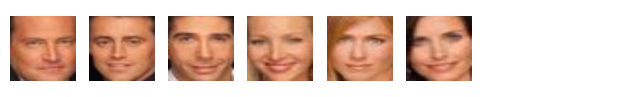

In [29]:
# Specify a threshold for face detection
detection_threshold = 0.95

# Initialize MTCNN for face detection
mtcnn = MTCNN(
    image_size=160,
    margin=0,
    min_face_size=20,
    thresholds=[0.6, 0.7, 0.7],
    factor=0.709,
    post_process=False,
    select_largest=False,
    selection_method=None,
    keep_all=True,
    device=None
)

# Load pre-trained FaceNet model
resnet = InceptionResnetV1(pretrained='casia-webface').eval()

# sample combined images
img_paths = df[df['label']=='Combined'].sample(10)['path'].values

# Load an image containing faces as a RGB image
img = Image.open(img_paths[0]).convert("RGB")

# Detect faces in the image
boxes, probs = mtcnn.detect(img)
detection_mask = probs > face_detection_threshold
boxes = boxes[detection_mask]

# If faces are detected, extract embeddings
if boxes is not None:
    aligned = mtcnn(img)
    aligned = aligned[detection_mask]
    embeddings = resnet(aligned).detach()

    # Visualize faces
    fig, ax = plt.subplots(ncols=8, figsize=(8,1))

    for i in range(8):
        ax[i].axis('off')

    for i, a in enumerate(aligned):
        ax[i].imshow(np.uint8(a.permute(1, 2, 0)))
        if i > 7:
            break
        
    plt.show()